# Phân loại ảnh sản phẩm thời trang sử dụng MobileViT v3

## 1. Giới thiệu
* **Mục tiêu:** Xây dựng và so sánh các mô hình phân loại ảnh sản phẩm thời trang từ các thương hiệu khác nhau (Adidas, Uniqlo, Yame) sử dụng hai phiên bản MobileViT v3 (0.5 và 1.0).
* **Vấn đề cần giải quyết:** Tự động nhận diện và phân loại các loại sản phẩm thời trang (áo và quần) từ các thương hiệu khác nhau dựa trên hình ảnh, sử dụng mô hình hiệu quả và nhẹ.
* **Dataset:** Dữ liệu MANAGE.csv chứa thông tin về đường dẫn hình ảnh và nhãn phân loại tương ứng (ao_adidas, quan_adidas, ao_uniqlo, quan_uniqlo, ao_yame, quan_yame).
* **Kỹ thuật AI áp dụng:** Sử dụng MobileViT v3, một kiến trúc nhẹ kết hợp giữa Mobile Neural Networks và Vision Transformers, phù hợp cho các ứng dụng trên thiết bị di động.

## 2. Chuẩn bị Môi trường và Thư viện
* Cài đặt các thư viện cần thiết cho quá trình huấn luyện và đánh giá mô hình
* Import các thư viện và kiểm tra phiên bản

In [1]:
# Cài đặt các thư viện cần thiết (bỏ comment nếu cần cài đặt)
!pip install --quiet --upgrade pip
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install transformers datasets evaluate accelerate

# Import các thư viện cần thiết
# System Libraries
import os
import random
import numpy as np
import pandas as pd
from pathlib import Path

# PyTorch và Transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
try:
    import evaluate
except ImportError:
    !pip install --quiet evaluate
    import evaluate
from PIL import Image as PILImage
try:
    from transformers import (
        AutoImageProcessor, 
        AutoModelForImageClassification,
        MobileViTImageProcessor,
        MobileViTForImageClassification,
        TrainingArguments, 
        Trainer
    )
except ImportError:
    !pip install --quiet transformers
    from transformers import (
        AutoImageProcessor,
        AutoModelForImageClassification,
        MobileViTImageProcessor,
        MobileViTForImageClassification,
        TrainingArguments, 
        Trainer
    )
try:
    from datasets import load_dataset, Dataset as HFDataset, DatasetDict, Image, Features, ClassLabel
except ImportError:
    !pip install --quiet datasets
    from datasets import load_dataset, Dataset as HFDataset, DatasetDict, Image, Features, ClassLabel

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Kiểm tra phiên bản các thư viện chính
print("Python libraries versions:")
print(f"PyTorch: {torch.__version__}")
try:
    import transformers
    print(f"Transformers: {transformers.__version__}")
except:
    print("Transformers: Not imported")
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")

# Kiểm tra GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\Users\ASUS\Desktop\HK7\DEEP LEARNING\deep\Scripts\python.exe -m pip install --quiet --upgrade pip
c:\Users\ASUS\Desktop\HK7\DEEP LEARNING\deep\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Python libraries versions:
PyTorch: 2.4.1+cu118
Transformers: 4.45.2
NumPy: 1.26.4
Pandas: 2.2.2
Using device: cpu


## 3. Khám phá và Tiền xử lý Dữ liệu
* Tải và khám phá dữ liệu từ file MANAGE.csv
* Phân tích phân bố các nhãn trong dataset
* Xem trước một số hình ảnh mẫu từ các lớp
* Tiền xử lý dữ liệu và chuẩn bị cho quá trình huấn luyện

In [2]:
# Đọc dữ liệu từ file CSV
df = pd.read_csv("./MANAGE.csv")
df


,dir,label,title,color,decripsion,image_dir
0,1f6ac96bdbcf41888b7daf2d00173c5c_9366.jpg,ao_adidas,Áo Thun Graphic Badge of Sport In Hoa,Black,Chiếc áo thun phong cách biểu tượng với điểm n...,ao_adidas/1f6ac96bdbcf41888b7daf2d00173c5c_936...
1,9183cfc4ec0141d0b0bbdef51bd6ec68_9366.jpg,ao_adidas,Áo Khoác Own the Run,White,Chiếc áo khoác chạy bộ cản gió có sử dụng chất...,ao_adidas/9183cfc4ec0141d0b0bbdef51bd6ec68_936...
2,c4778cff7cc24601ba15af4600f3ca4a_9366.jpg,ao_adidas,Áo Thun Oversize Yoga Studio,Preloved Red,Chiếc áo thun yoga có nguồn gốc tự nhiên.Mạnh ...,ao_adidas/c4778cff7cc24601ba15af4600f3ca4a_936...
3,a593596b4ea94574beec630314f4a5e0_9366.jpg,ao_adidas,Áo Tank Top Jersey Cotton One Basketball,Cream White Mel.,Chiếc áo thun cotton tôn vinh bộ môn bóng rổ.S...,ao_adidas/a593596b4ea94574beec630314f4a5e0_936...
4,00c9cbf1eb044c6a9934afaa00de8e5b_9366.jpg,ao_adidas,Áo Thun Khóa Kéo Lửng Dài Tay Collective Power,Clay Strata,Chiếc áo chạy bộ ôm sát với các chi tiết xếp n...,ao_adidas/00c9cbf1eb044c6a9934afaa00de8e5b_936...
...,...,...,...,...,...,...
7147,f8b32ca0-5fa3-a700-3067-001931340ae4.jpg,quan_yame,Quần Dài Lưng Thun Ống Đứng Vải Denim Co Giãn ...,Xanh Rêu,\nMô tả sản phẩm\nQuần Dài Trouser Đơn Giản Y ...,quan_yame/f8b32ca0-5fa3-a700-3067-001931340ae4...
7148,77d0962a-d3ec-af00-bbd5-00194cb1f951.jpg,quan_yame,Quần Dài Lưng Gài Ống Đứng Vải Denim Co Giãn T...,Nâu Đậm,\nMô tả sản phẩm\nQuần Dài Vải Tối Giản M9Chất...,quan_yame/77d0962a-d3ec-af00-bbd5-00194cb1f951...
7149,421e0533-017a-3801-d6a5-001999bf4794.jpg,quan_yame,Quần Jean Lưng Gài Ống Đứng Vải Cotton Co Giãn...,Xanh Đậm,\nMô tả sản phẩm\nQuần Jean Slimfit 12VAHDT Vạ...,quan_yame/421e0533-017a-3801-d6a5-001999bf4794...
7150,315764eb-5068-3b00-ad44-001af08675fb.jpg,quan_yame,Quần Jean Lưng Gài Ống Đứng Vải Cotton Co Giãn...,Xanh Dương,\nMô tả sản phẩm\nChất liệu: Jean Cotton Spand...,quan_yame/315764eb-5068-3b00-ad44-001af08675fb...


In [3]:
# Kiểm tra và loại bỏ các ảnh không hợp lệ hoặc không tồn tại
print("Kiểm tra và loại bỏ các ảnh không hợp lệ...")

invalid_indices = []
for index, row in df.iterrows():
    img_path = row['image_dir']
    try:
        # Thử mở ảnh để kiểm tra tính hợp lệ
        img = PILImage.open(img_path)
        img.verify() # Kiểm tra tính toàn vẹn của file ảnh
        img.close() # Đóng file sau khi kiểm tra
    except Exception as e:
        print(f"Ảnh không hợp lệ hoặc không tìm thấy: {img_path} - Lỗi: {e}")
        invalid_indices.append(index)

# Loại bỏ các dòng có ảnh không hợp lệ khỏi DataFrame
if invalid_indices:
    print(f"\nTìm thấy {len(invalid_indices)} ảnh không hợp lệ. Đang loại bỏ khỏi DataFrame.")
    df_cleaned = df.drop(invalid_indices).reset_index(drop=True)
    print(f"Kích thước DataFrame sau khi loại bỏ: {df_cleaned.shape}")
    
    # Cập nhật DataFrame gốc
    df = df_cleaned
    
    # Lưu DataFrame đã làm sạch trở lại file CSV
    try:
        df.to_csv("./MANAGE.csv", index=False)
        print("Đã lưu DataFrame đã làm sạch vào ./MANAGE.csv")
    except Exception as e:
        print(f"Lỗi khi lưu file CSV: {e}")
else:
    print("\nKhông tìm thấy ảnh không hợp lệ nào.")


Kiểm tra và loại bỏ các ảnh không hợp lệ...

Không tìm thấy ảnh không hợp lệ nào.



DataFrame sau khi làm sạch:
DataFrame shape: (7152, 6)


,dir,label,title,color,decripsion,image_dir
0,1f6ac96bdbcf41888b7daf2d00173c5c_9366.jpg,ao_adidas,Áo Thun Graphic Badge of Sport In Hoa,Black,Chiếc áo thun phong cách biểu tượng với điểm n...,ao_adidas/1f6ac96bdbcf41888b7daf2d00173c5c_936...
1,9183cfc4ec0141d0b0bbdef51bd6ec68_9366.jpg,ao_adidas,Áo Khoác Own the Run,White,Chiếc áo khoác chạy bộ cản gió có sử dụng chất...,ao_adidas/9183cfc4ec0141d0b0bbdef51bd6ec68_936...
2,c4778cff7cc24601ba15af4600f3ca4a_9366.jpg,ao_adidas,Áo Thun Oversize Yoga Studio,Preloved Red,Chiếc áo thun yoga có nguồn gốc tự nhiên.Mạnh ...,ao_adidas/c4778cff7cc24601ba15af4600f3ca4a_936...
3,a593596b4ea94574beec630314f4a5e0_9366.jpg,ao_adidas,Áo Tank Top Jersey Cotton One Basketball,Cream White Mel.,Chiếc áo thun cotton tôn vinh bộ môn bóng rổ.S...,ao_adidas/a593596b4ea94574beec630314f4a5e0_936...
4,00c9cbf1eb044c6a9934afaa00de8e5b_9366.jpg,ao_adidas,Áo Thun Khóa Kéo Lửng Dài Tay Collective Power,Clay Strata,Chiếc áo chạy bộ ôm sát với các chi tiết xếp n...,ao_adidas/00c9cbf1eb044c6a9934afaa00de8e5b_936...


DataFrame shape: (7152, 6)


,dir,label,title,color,decripsion,image_dir
0,1f6ac96bdbcf41888b7daf2d00173c5c_9366.jpg,ao_adidas,Áo Thun Graphic Badge of Sport In Hoa,Black,Chiếc áo thun phong cách biểu tượng với điểm n...,ao_adidas/1f6ac96bdbcf41888b7daf2d00173c5c_936...
1,9183cfc4ec0141d0b0bbdef51bd6ec68_9366.jpg,ao_adidas,Áo Khoác Own the Run,White,Chiếc áo khoác chạy bộ cản gió có sử dụng chất...,ao_adidas/9183cfc4ec0141d0b0bbdef51bd6ec68_936...
2,c4778cff7cc24601ba15af4600f3ca4a_9366.jpg,ao_adidas,Áo Thun Oversize Yoga Studio,Preloved Red,Chiếc áo thun yoga có nguồn gốc tự nhiên.Mạnh ...,ao_adidas/c4778cff7cc24601ba15af4600f3ca4a_936...
3,a593596b4ea94574beec630314f4a5e0_9366.jpg,ao_adidas,Áo Tank Top Jersey Cotton One Basketball,Cream White Mel.,Chiếc áo thun cotton tôn vinh bộ môn bóng rổ.S...,ao_adidas/a593596b4ea94574beec630314f4a5e0_936...
4,00c9cbf1eb044c6a9934afaa00de8e5b_9366.jpg,ao_adidas,Áo Thun Khóa Kéo Lửng Dài Tay Collective Power,Clay Strata,Chiếc áo chạy bộ ôm sát với các chi tiết xếp n...,ao_adidas/00c9cbf1eb044c6a9934afaa00de8e5b_936...



DataFrame columns: ['dir', 'label', 'title', 'color', 'decripsion', 'image_dir']

Unique labels: ['ao_adidas' 'quan_adidas' 'ao_uniqlo' 'quan_uniqlo' 'ao_yame' 'quan_yame']

Label distribution:


label
ao_adidas      2098
quan_adidas    1716
ao_yame        1060
ao_uniqlo       924
quan_uniqlo     792
quan_yame       562
Name: count, dtype: int64

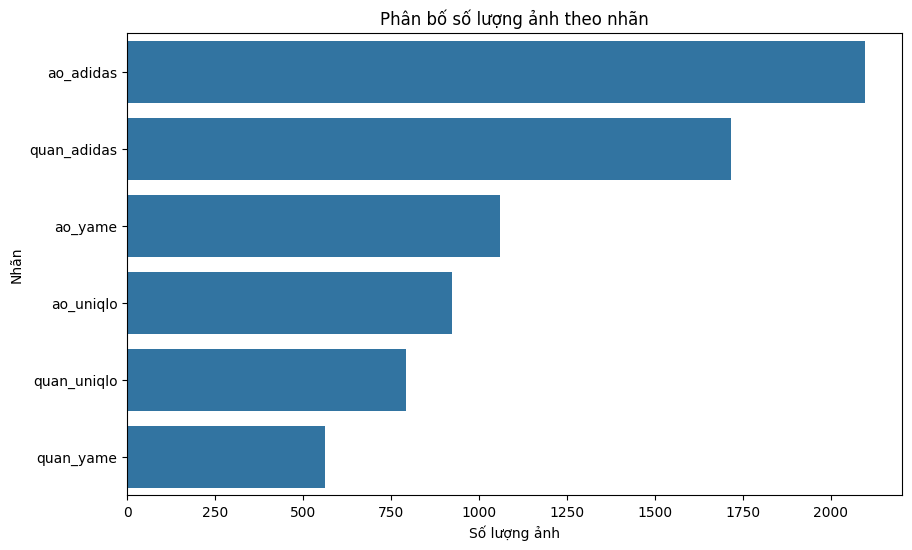

In [4]:

# Hiển thị lại thông tin DataFrame sau khi làm sạch
print("\nDataFrame sau khi làm sạch:")
print("DataFrame shape:", df.shape)
display(df.head())
# Hiển thị một vài dòng để kiểm tra dữ liệu
print("DataFrame shape:", df.shape)
display(df.head())

# Kiểm tra các cột trong DataFrame
print("\nDataFrame columns:", df.columns.tolist())

# Kiểm tra các giá trị độc đáo trong cột label
print("\nUnique labels:", df['label'].unique())

# Phân tích phân bố nhãn
label_counts = df['label'].value_counts()
print("\nLabel distribution:")
display(label_counts)

# Vẽ biểu đồ phân bố nhãn
plt.figure(figsize=(10, 6))
sns.countplot(y=df['label'], order=label_counts.index)
plt.title('Phân bố số lượng ảnh theo nhãn')
plt.xlabel('Số lượng ảnh')
plt.ylabel('Nhãn')
plt.show()

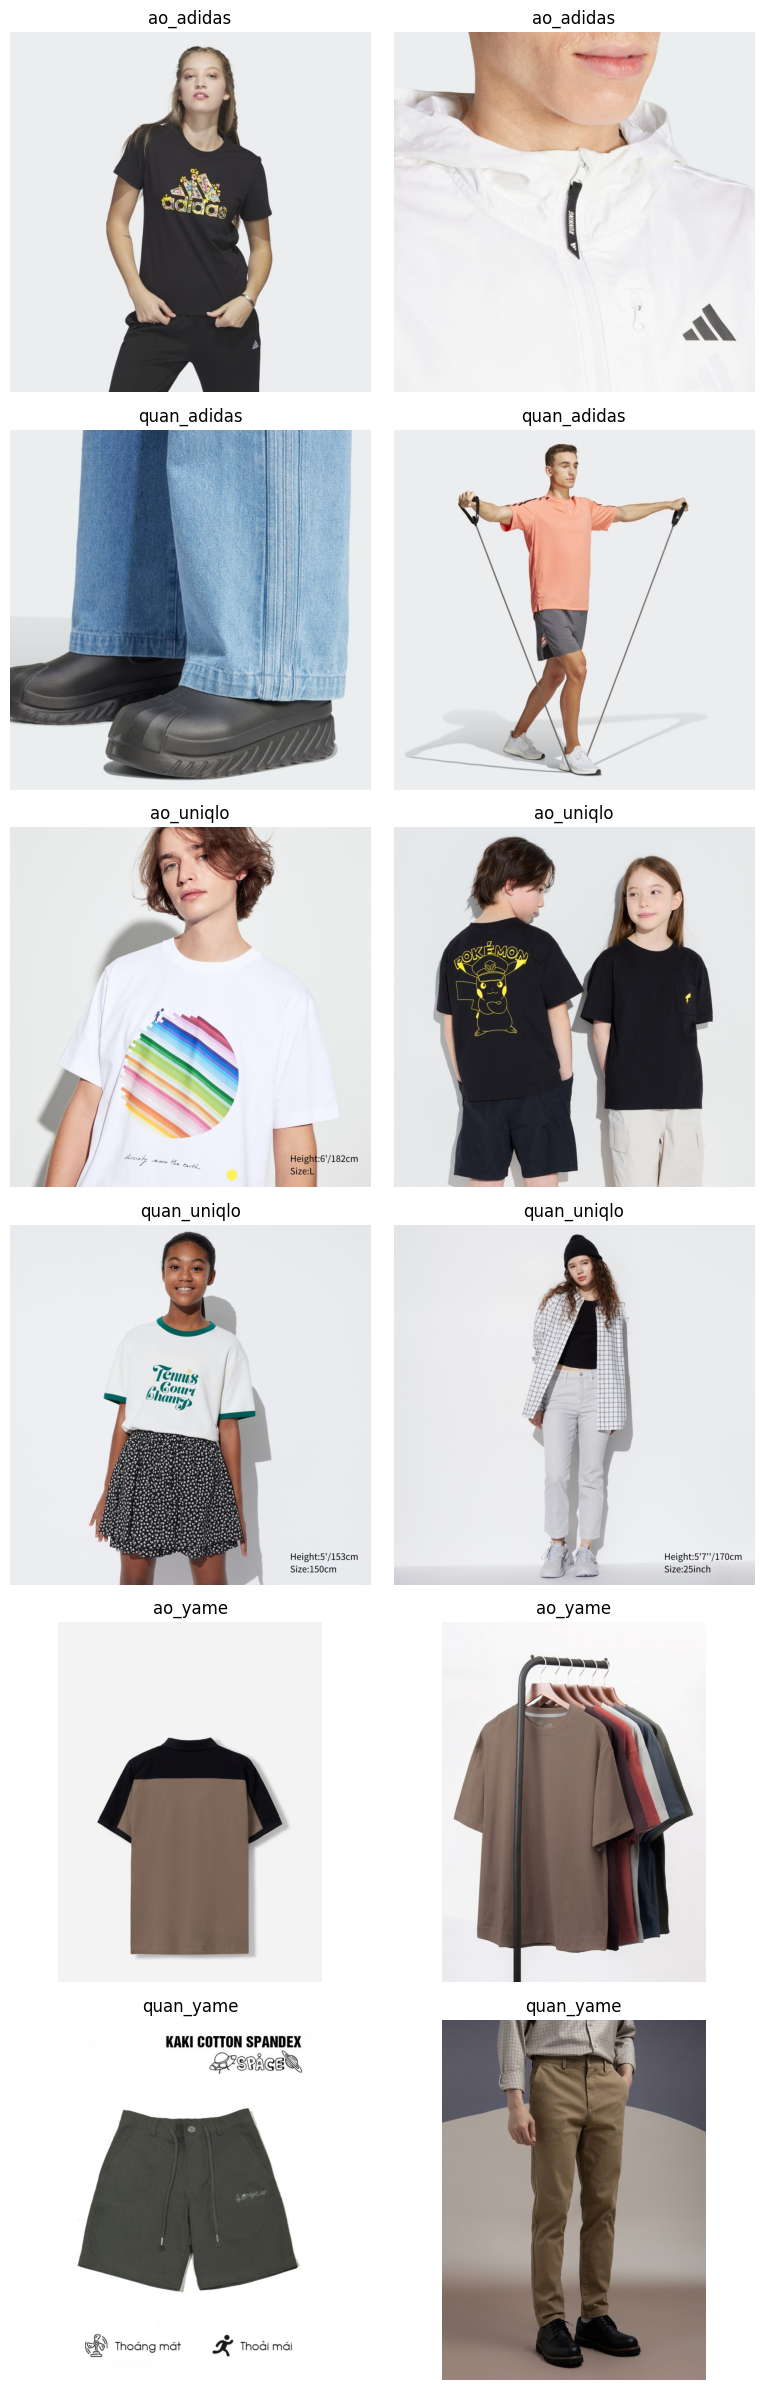

In [5]:
# Hàm để hiển thị một số ảnh mẫu từ mỗi lớp
def display_sample_images(dataframe, label_column='label', image_path_column='image_dir', n_samples=2):
    unique_labels = dataframe[label_column].unique()
    
    # Tạo lưới để hiển thị ảnh
    n_labels = len(unique_labels)
    fig, axes = plt.subplots(n_labels, n_samples, figsize=(n_samples * 4, n_labels * 4))
    
    for i, label in enumerate(unique_labels):
        # Lọc dữ liệu theo nhãn
        label_df = dataframe[dataframe[label_column] == label]
        
        # Lấy ngẫu nhiên n_samples ảnh
        sample_indices = np.random.choice(label_df.index, min(n_samples, len(label_df)), replace=False)
        
        for j, idx in enumerate(sample_indices):
            # Đọc ảnh
            img_path = label_df.iloc[j][image_path_column]
            try:
                img = PILImage.open(img_path)
                
                # Hiển thị ảnh
                if n_labels > 1:
                    ax = axes[i, j]
                else:
                    ax = axes[j]
                ax.imshow(img)
                ax.set_title(f"{label}")
                ax.axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
    
    plt.tight_layout()
    plt.show()

# Hiển thị mẫu ảnh từ mỗi lớp
try:
    display_sample_images(df)
except Exception as e:
    print(f"Error displaying images: {e}")
    print("Kiểm tra đường dẫn ảnh có thể không chính xác, cần điều chỉnh đường dẫn gốc.")

In [6]:
# Điều chỉnh đường dẫn ảnh nếu cần
# Trong một số trường hợp, đường dẫn có thể cần phải được thêm vào tiền tố của thư mục gốc

# Kiểm tra xem một vài đường dẫn ảnh đầu tiên có tồn tại không
print("Kiểm tra các đường dẫn ảnh:")
for i, img_path in enumerate(df['image_dir'].head(3)):
    path_exists = os.path.exists(img_path)
    print(f"Image {i+1}: {img_path} - {'Exists' if path_exists else 'Not found'}")

# Nếu đường dẫn không chính xác, chúng ta có thể cần điều chỉnh
base_dir = "./archive"  # Thay đổi nếu cần
if not all(os.path.exists(path) for path in df['image_dir'].head(3)):
    print("\nĐiều chỉnh đường dẫn với thư mục gốc...")
    df['image_dir_fixed'] = df['image_dir'].apply(lambda x: os.path.join(base_dir, x) if not os.path.exists(x) else x)
    
    # Kiểm tra lại các đường dẫn đã điều chỉnh
    print("\nKiểm tra lại các đường dẫn sau khi điều chỉnh:")
    for i, img_path in enumerate(df['image_dir_fixed'].head(3)):
        path_exists = os.path.exists(img_path)
        print(f"Image {i+1}: {img_path} - {'Exists' if path_exists else 'Not found'}")
else:
    df['image_dir_fixed'] = df['image_dir']

Kiểm tra các đường dẫn ảnh:
Image 1: ao_adidas/1f6ac96bdbcf41888b7daf2d00173c5c_9366.jpg - Exists
Image 2: ao_adidas/9183cfc4ec0141d0b0bbdef51bd6ec68_9366.jpg - Exists
Image 3: ao_adidas/c4778cff7cc24601ba15af4600f3ca4a_9366.jpg - Exists


In [7]:
# Chuẩn bị dữ liệu cho mô hình MobileViT
# Chia dữ liệu thành tập huấn luyện, xác thực và kiểm tra
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành train (70%), val (15%), test (15%)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")
print(f"Test set: {len(test_df)} images")

# Chuyển đổi DataFrame thành định dạng Hugging Face Datasets
def create_hf_dataset(dataframe, img_col='image_dir_fixed', label_col='label'):
    # Tạo ánh xạ từ nhãn văn bản sang số nguyên
    label_to_id = {label: idx for idx, label in enumerate(sorted(dataframe[label_col].unique()))}
    id_to_label = {v: k for k, v in label_to_id.items()}
    
    # Hàm đọc và xử lý ảnh
    def process_example(example):
        try:
            # Đọc ảnh từ đường dẫn
            image = PILImage.open(example[img_col])
            if image.mode != 'RGB':
                image = image.convert('RGB')
            
            # Chuyển đổi nhãn văn bản sang số nguyên
            label_id = label_to_id[example[label_col]]
            
            return {
                'image': image,
                'label': label_id,
                'label_text': example[label_col]
            }
        except Exception as e:
            print(f"Error processing image {example[img_col]}: {e}")
            return None
    
    # Xử lý từng mẫu dữ liệu
    dataset_dict = {'image': [], 'label': [], 'label_text': []}
    for _, row in dataframe.iterrows():
        example = process_example(row)
        if example:
            dataset_dict['image'].append(example['image'])
            dataset_dict['label'].append(example['label'])
            dataset_dict['label_text'].append(example['label_text'])
    
    # Tạo dataset từ dictionary
    dataset = HFDataset.from_dict(dataset_dict)
    
    return dataset, label_to_id, id_to_label

# Tạo Hugging Face datasets cho train, val và test
train_dataset, label_to_id, id_to_label = create_hf_dataset(train_df)
val_dataset, _, _ = create_hf_dataset(val_df)
test_dataset, _, _ = create_hf_dataset(test_df)

# Tổ chức các tập dữ liệu vào DatasetDict
dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})

print("\nHugging Face Dataset created:")
print(dataset_dict)

# Lưu thông tin ánh xạ nhãn để sử dụng sau này
print("\nLabel mapping:")
for label, idx in label_to_id.items():
    print(f"{idx}: {label}")

Train set: 5006 images
Validation set: 1073 images
Test set: 1073 images



Hugging Face Dataset created:
DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'label_text'],
        num_rows: 5006
    })
    validation: Dataset({
        features: ['image', 'label', 'label_text'],
        num_rows: 1073
    })
    test: Dataset({
        features: ['image', 'label', 'label_text'],
        num_rows: 1073
    })
})

Label mapping:
0: ao_adidas
1: ao_uniqlo
2: ao_yame
3: quan_adidas
4: quan_uniqlo
5: quan_yame


## 4. Xây dựng và Cấu hình Mô hình MobileViT
* Tải processor và hai mô hình MobileViT (v3-0.5 và v3-1.0)
* Cấu hình models với số lớp output phù hợp
* Thiết lập các tham số huấn luyện

In [8]:
# Định nghĩa các model checkpoints cho MobileViT-v3
mobilevit_small_checkpoint = "apple/mobilevit-xx-small" # Tương tự MobileViT v3-0.5 về kích thước
mobilevit_large_checkpoint = "apple/mobilevit-small"    # Tương tự MobileViT v3-1.0 về kích thước

# Tải các image processors
mobilevit_small_processor = AutoImageProcessor.from_pretrained(mobilevit_small_checkpoint)
mobilevit_large_processor = AutoImageProcessor.from_pretrained(mobilevit_large_checkpoint)

# Hàm tiền xử lý dữ liệu cho mô hình MobileViT
def preprocess_images(examples, processor):
    images = examples['image']
    # Xử lý ảnh với image processor
    inputs = processor(images=images, return_tensors="pt", padding=True)
    # Thêm nhãn
    inputs['labels'] = examples['label']
    return inputs

# Áp dụng tiền xử lý cho mô hình small (0.5)
processed_datasets_small = dataset_dict.map(
    lambda examples: preprocess_images(examples, mobilevit_small_processor),
    batched=True,
    remove_columns=['image', 'label_text'],
)

# Áp dụng tiền xử lý cho mô hình large (1.0)
processed_datasets_large = dataset_dict.map(
    lambda examples: preprocess_images(examples, mobilevit_large_processor),
    batched=True,
    remove_columns=['image', 'label_text'],
)

print("Processed datasets format for MobileViT v3-0.5:")
print(processed_datasets_small)
print("\nProcessed datasets format for MobileViT v3-1.0:")
print(processed_datasets_large)

Map:   0%|          | 0/5006 [00:00<?, ? examples/s]c:\Users\ASUS\Desktop\HK7\DEEP LEARNING\deep\Lib\site-packages\transformers\image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `MobileViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Map: 100%|██████████| 1073/1073 [00:20<00:00, 52.71 examples/s]

Processed datasets format for MobileViT v3-0.5:
DatasetDict({
    train: Dataset({
        features: ['label', 'pixel_values', 'labels'],
        num_rows: 5006
    })
    validation: Dataset({
        features: ['label', 'pixel_values', 'labels'],
        num_rows: 1073
    })
    test: Dataset({
        features: ['label', 'pixel_values', 'labels'],
        num_rows: 1073
    })
})

Processed datasets format for MobileViT v3-1.0:
DatasetDict({
    train: Dataset({
        features: ['label', 'pixel_values', 'labels'],
        num_rows: 5006
    })
    validation: Dataset({
        features: ['label', 'pixel_values', 'labels'],
        num_rows: 1073
    })
    test: Dataset({
        features: ['label', 'pixel_values', 'labels'],
        num_rows: 1073
    })
})


In [9]:
# Tải và thiết lập các mô hình MobileViT
num_labels = len(label_to_id)
id2label = id_to_label
label2id = label_to_id

# Tải mô hình MobileViT v3-0.5 (small)
model_small = AutoModelForImageClassification.from_pretrained(
    mobilevit_small_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # Bỏ qua các sai lệch về kích thước
)

# Tải mô hình MobileViT v3-1.0 (large)
model_large = AutoModelForImageClassification.from_pretrained(
    mobilevit_large_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

print(f"Model Small (v3-0.5) architecture: {model_small.__class__.__name__}")
print(f"Model Large (v3-1.0) architecture: {model_large.__class__.__name__}")
print(f"Number of output labels: {num_labels}")

# So sánh số lượng tham số của hai mô hình
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

small_params = count_parameters(model_small)
large_params = count_parameters(model_large)

print(f"\nSố lượng tham số của MobileViT v3-0.5: {small_params:,}")
print(f"Số lượng tham số của MobileViT v3-1.0: {large_params:,}")
print(f"Tỷ lệ tham số (Large/Small): {large_params/small_params:.2f}x")

c:\Users\ASUS\Desktop\HK7\DEEP LEARNING\deep\Lib\site-packages\huggingface_hub\file_download.py:147: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\ASUS\.cache\huggingface\hub\models--apple--mobilevit-xx-small. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of MobileViTForImageClassification were not initialized from the model checkpoint at ap

Model Small (v3-0.5) architecture: MobileViTForImageClassification
Model Large (v3-1.0) architecture: MobileViTForImageClassification
Number of output labels: 6

Số lượng tham số của MobileViT v3-0.5: 952,950
Số lượng tham số của MobileViT v3-1.0: 4,941,478
Tỷ lệ tham số (Large/Small): 5.19x


## 5. Huấn luyện Mô hình
* Định nghĩa các metrics để đánh giá
* Thiết lập tham số huấn luyện
* Huấn luyện cả hai mô hình 
* So sánh quá trình huấn luyện

In [10]:
# Định nghĩa hàm tính toán metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    
    # Tính toán accuracy và các metrics khác
    accuracy = accuracy_score(labels, predictions)
    
    # Tạo classification report
    report_dict = classification_report(
        labels, predictions, target_names=list(id2label.values()), output_dict=True
    )
    
    # Lấy các metrics từ report
    metrics = {
        "accuracy": accuracy,
    }
    
    # Thêm precision, recall và f1 cho từng lớp
    for label_name in id2label.values():
        label_metrics = report_dict[label_name]
        metrics[f"precision_{label_name}"] = label_metrics['precision']
        metrics[f"recall_{label_name}"] = label_metrics['recall']
        metrics[f"f1_{label_name}"] = label_metrics['f1-score']
    
    return metrics

In [11]:
# Định nghĩa tham số huấn luyện cho mô hình MobileViT v3-0.5 (small)
training_args_small = TrainingArguments(
    output_dir="./results/mobilevit_small_fashion_classifier",
    per_device_train_batch_size=16,  # Batch size lớn hơn do mô hình nhỏ hơn
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    fp16=torch.cuda.is_available(),
    learning_rate=5e-5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="tensorboard",
)

# Khởi tạo Trainer cho mô hình small
trainer_small = Trainer(
    model=model_small,
    args=training_args_small,
    train_dataset=processed_datasets_small["train"],
    eval_dataset=processed_datasets_small["validation"],
    tokenizer=mobilevit_small_processor,
    compute_metrics=compute_metrics,
)

# Định nghĩa tham số huấn luyện cho mô hình MobileViT v3-1.0 (large)
training_args_large = TrainingArguments(
    output_dir="./results/mobilevit_large_fashion_classifier",
    per_device_train_batch_size=8,  # Batch size nhỏ hơn do mô hình lớn hơn
    per_device_eval_batch_size=8,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=10,
    fp16=torch.cuda.is_available(),
    learning_rate=3e-5,  # Learning rate nhỏ hơn cho mô hình lớn
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    report_to="tensorboard",
)

# Khởi tạo Trainer cho mô hình large
trainer_large = Trainer(
    model=model_large,
    args=training_args_large,
    train_dataset=processed_datasets_large["train"],
    eval_dataset=processed_datasets_large["validation"],
    tokenizer=mobilevit_large_processor,
    compute_metrics=compute_metrics,
)

c:\Users\ASUS\Desktop\HK7\DEEP LEARNING\deep\Lib\site-packages\transformers\training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [12]:
# Huấn luyện mô hình MobileViT v3-0.5 (small)
print("Huấn luyện mô hình MobileViT v3-0.5 (small)")
train_results_small = trainer_small.train()

# Hiển thị kết quả huấn luyện
print("\nKết quả huấn luyện MobileViT v3-0.5:")
print(train_results_small)

# Đánh giá mô hình trên tập validation
eval_results_small = trainer_small.evaluate()
print("\nKết quả đánh giá MobileViT v3-0.5 trên tập validation:")
print(  )

# Lưu mô hình
trainer_small.save_model("./models/mobilevit_small_fashion_classifier")
print("Đã lưu mô hình MobileViT v3-0.5 tại ./models/mobilevit_small_fashion_classifier")

Huấn luyện mô hình MobileViT v3-0.5 (small)


                                                    
 10%|█         | 313/3130 [16:27<1:31:48,  1.96s/it]

{'eval_loss': 1.1844836473464966, 'eval_accuracy': 0.6859273066169618, 'eval_precision_ao_adidas': 0.8571428571428571, 'eval_recall_ao_adidas': 0.535031847133758, 'eval_f1_ao_adidas': 0.6588235294117647, 'eval_precision_ao_uniqlo': 0.5721925133689839, 'eval_recall_ao_uniqlo': 0.7697841726618705, 'eval_f1_ao_uniqlo': 0.656441717791411, 'eval_precision_ao_yame': 0.5513513513513514, 'eval_recall_ao_yame': 0.6415094339622641, 'eval_f1_ao_yame': 0.5930232558139535, 'eval_precision_quan_adidas': 0.7164179104477612, 'eval_recall_quan_adidas': 0.7470817120622568, 'eval_f1_quan_adidas': 0.7314285714285714, 'eval_precision_quan_uniqlo': 0.865546218487395, 'eval_recall_quan_uniqlo': 0.865546218487395, 'eval_f1_quan_uniqlo': 0.865546218487395, 'eval_precision_quan_yame': 0.5423728813559322, 'eval_recall_quan_yame': 0.7529411764705882, 'eval_f1_quan_yame': 0.6305418719211823, 'eval_runtime': 133.6917, 'eval_samples_per_second': 8.026, 'eval_steps_per_second': 0.509, 'epoch': 1.0}


 16%|█▌        | 500/3130 [24:34<1:50:21,  2.52s/it] 

{'loss': 1.382, 'grad_norm': 4.740224361419678, 'learning_rate': 4.201277955271566e-05, 'epoch': 1.6}


                                                    
 20%|██        | 626/3130 [32:12<1:22:51,  1.99s/it]

{'eval_loss': 0.8824223875999451, 'eval_accuracy': 0.7632805219012115, 'eval_precision_ao_adidas': 0.8914027149321267, 'eval_recall_ao_adidas': 0.6273885350318471, 'eval_f1_ao_adidas': 0.7364485981308411, 'eval_precision_ao_uniqlo': 0.7323943661971831, 'eval_recall_ao_uniqlo': 0.7482014388489209, 'eval_f1_ao_uniqlo': 0.7402135231316725, 'eval_precision_ao_yame': 0.6285714285714286, 'eval_recall_ao_yame': 0.8301886792452831, 'eval_f1_ao_yame': 0.7154471544715447, 'eval_precision_quan_adidas': 0.7741935483870968, 'eval_recall_quan_adidas': 0.8404669260700389, 'eval_f1_quan_adidas': 0.8059701492537313, 'eval_precision_quan_uniqlo': 0.781021897810219, 'eval_recall_quan_uniqlo': 0.8991596638655462, 'eval_f1_quan_uniqlo': 0.8359375, 'eval_precision_quan_yame': 0.75, 'eval_recall_quan_yame': 0.7411764705882353, 'eval_f1_quan_yame': 0.7455621301775148, 'eval_runtime': 131.7143, 'eval_samples_per_second': 8.146, 'eval_steps_per_second': 0.516, 'epoch': 2.0}


                                                     
 30%|███       | 939/3130 [47:58<1:09:42,  1.91s/it]

{'eval_loss': 0.5901219248771667, 'eval_accuracy': 0.8406337371854613, 'eval_precision_ao_adidas': 0.8932384341637011, 'eval_recall_ao_adidas': 0.7993630573248408, 'eval_f1_ao_adidas': 0.8436974789915966, 'eval_precision_ao_uniqlo': 0.7454545454545455, 'eval_recall_ao_uniqlo': 0.8848920863309353, 'eval_f1_ao_uniqlo': 0.8092105263157895, 'eval_precision_ao_yame': 0.8676470588235294, 'eval_recall_ao_yame': 0.7421383647798742, 'eval_f1_ao_yame': 0.8, 'eval_precision_quan_adidas': 0.8049645390070922, 'eval_recall_quan_adidas': 0.8832684824902723, 'eval_f1_quan_adidas': 0.8423005565862709, 'eval_precision_quan_uniqlo': 0.864, 'eval_recall_quan_uniqlo': 0.907563025210084, 'eval_f1_quan_uniqlo': 0.8852459016393442, 'eval_precision_quan_yame': 0.8928571428571429, 'eval_recall_quan_yame': 0.8823529411764706, 'eval_f1_quan_yame': 0.8875739644970414, 'eval_runtime': 129.0251, 'eval_samples_per_second': 8.316, 'eval_steps_per_second': 0.527, 'epoch': 3.0}


 32%|███▏      | 1000/3130 [50:36<1:40:30,  2.83s/it]

{'loss': 0.8331, 'grad_norm': 11.983304977416992, 'learning_rate': 3.402555910543131e-05, 'epoch': 3.19}


                                                       
 40%|████      | 1252/3130 [1:04:14<1:00:14,  1.92s/it]

{'eval_loss': 0.4856545329093933, 'eval_accuracy': 0.869524697110904, 'eval_precision_ao_adidas': 0.9239543726235742, 'eval_recall_ao_adidas': 0.7738853503184714, 'eval_f1_ao_adidas': 0.8422876949740035, 'eval_precision_ao_uniqlo': 0.8741258741258742, 'eval_recall_ao_uniqlo': 0.8992805755395683, 'eval_f1_ao_uniqlo': 0.8865248226950354, 'eval_precision_ao_yame': 0.8488372093023255, 'eval_recall_ao_yame': 0.9182389937106918, 'eval_f1_ao_yame': 0.8821752265861027, 'eval_precision_quan_adidas': 0.8140350877192982, 'eval_recall_quan_adidas': 0.9027237354085603, 'eval_f1_quan_adidas': 0.8560885608856088, 'eval_precision_quan_uniqlo': 0.8888888888888888, 'eval_recall_quan_uniqlo': 0.9411764705882353, 'eval_f1_quan_uniqlo': 0.9142857142857143, 'eval_precision_quan_yame': 0.8928571428571429, 'eval_recall_quan_yame': 0.8823529411764706, 'eval_f1_quan_yame': 0.8875739644970414, 'eval_runtime': 145.2262, 'eval_samples_per_second': 7.388, 'eval_steps_per_second': 0.468, 'epoch': 4.0}


 48%|████▊     | 1500/3130 [1:16:15<1:15:22,  2.77s/it] 

{'loss': 0.6046, 'grad_norm': 9.852116584777832, 'learning_rate': 2.6038338658146967e-05, 'epoch': 4.79}


                                                       
 50%|█████     | 1565/3130 [1:21:28<50:31,  1.94s/it]

{'eval_loss': 0.39997828006744385, 'eval_accuracy': 0.8816402609506058, 'eval_precision_ao_adidas': 0.9151943462897526, 'eval_recall_ao_adidas': 0.8248407643312102, 'eval_f1_ao_adidas': 0.8676716917922948, 'eval_precision_ao_uniqlo': 0.8873239436619719, 'eval_recall_ao_uniqlo': 0.9064748201438849, 'eval_f1_ao_uniqlo': 0.896797153024911, 'eval_precision_ao_yame': 0.9032258064516129, 'eval_recall_ao_yame': 0.8805031446540881, 'eval_f1_ao_yame': 0.89171974522293, 'eval_precision_quan_adidas': 0.818815331010453, 'eval_recall_quan_adidas': 0.914396887159533, 'eval_f1_quan_adidas': 0.8639705882352942, 'eval_precision_quan_uniqlo': 0.9016393442622951, 'eval_recall_quan_uniqlo': 0.9243697478991597, 'eval_f1_quan_uniqlo': 0.9128630705394191, 'eval_precision_quan_yame': 0.9047619047619048, 'eval_recall_quan_yame': 0.8941176470588236, 'eval_f1_quan_yame': 0.8994082840236687, 'eval_runtime': 138.6122, 'eval_samples_per_second': 7.741, 'eval_steps_per_second': 0.491, 'epoch': 5.0}


                                                        
 60%|██████    | 1878/3130 [1:37:59<47:07,  2.26s/it]

{'eval_loss': 0.359530508518219, 'eval_accuracy': 0.8788443616029823, 'eval_precision_ao_adidas': 0.8726114649681529, 'eval_recall_ao_adidas': 0.8726114649681529, 'eval_f1_ao_adidas': 0.8726114649681529, 'eval_precision_ao_uniqlo': 0.8431372549019608, 'eval_recall_ao_uniqlo': 0.9280575539568345, 'eval_f1_ao_uniqlo': 0.8835616438356164, 'eval_precision_ao_yame': 0.8987341772151899, 'eval_recall_ao_yame': 0.8930817610062893, 'eval_f1_ao_yame': 0.8958990536277602, 'eval_precision_quan_adidas': 0.8627450980392157, 'eval_recall_quan_adidas': 0.8560311284046692, 'eval_f1_quan_adidas': 0.859375, 'eval_precision_quan_uniqlo': 0.926605504587156, 'eval_recall_quan_uniqlo': 0.8487394957983193, 'eval_f1_quan_uniqlo': 0.8859649122807017, 'eval_precision_quan_yame': 0.9166666666666666, 'eval_recall_quan_yame': 0.9058823529411765, 'eval_f1_quan_yame': 0.9112426035502958, 'eval_runtime': 156.0037, 'eval_samples_per_second': 6.878, 'eval_steps_per_second': 0.436, 'epoch': 6.0}


 64%|██████▍   | 2000/3130 [1:44:01<50:41,  2.69s/it]   

{'loss': 0.5062, 'grad_norm': 17.72583770751953, 'learning_rate': 1.805111821086262e-05, 'epoch': 6.39}


                                                     
 70%|███████   | 2191/3130 [1:54:49<31:56,  2.04s/it]

{'eval_loss': 0.32644444704055786, 'eval_accuracy': 0.8928238583410997, 'eval_precision_ao_adidas': 0.89419795221843, 'eval_recall_ao_adidas': 0.8343949044585988, 'eval_f1_ao_adidas': 0.8632619439868204, 'eval_precision_ao_uniqlo': 0.9214285714285714, 'eval_recall_ao_uniqlo': 0.9280575539568345, 'eval_f1_ao_uniqlo': 0.9247311827956989, 'eval_precision_ao_yame': 0.9483870967741935, 'eval_recall_ao_yame': 0.9245283018867925, 'eval_f1_ao_yame': 0.9363057324840764, 'eval_precision_quan_adidas': 0.8220640569395018, 'eval_recall_quan_adidas': 0.8988326848249028, 'eval_f1_quan_adidas': 0.8587360594795539, 'eval_precision_quan_uniqlo': 0.9316239316239316, 'eval_recall_quan_uniqlo': 0.9159663865546218, 'eval_f1_quan_uniqlo': 0.923728813559322, 'eval_precision_quan_yame': 0.9195402298850575, 'eval_recall_quan_yame': 0.9411764705882353, 'eval_f1_quan_yame': 0.9302325581395349, 'eval_runtime': 132.6607, 'eval_samples_per_second': 8.088, 'eval_steps_per_second': 0.513, 'epoch': 7.0}


 80%|███████▉  | 2500/3130 [2:08:31<26:23,  2.51s/it]   

{'loss': 0.435, 'grad_norm': 25.148618698120117, 'learning_rate': 1.0063897763578276e-05, 'epoch': 7.99}


                                                     
 80%|████████  | 2504/3130 [2:10:52<20:42,  1.99s/it]

{'eval_loss': 0.30856478214263916, 'eval_accuracy': 0.8918918918918919, 'eval_precision_ao_adidas': 0.9010238907849829, 'eval_recall_ao_adidas': 0.8407643312101911, 'eval_f1_ao_adidas': 0.8698517298187809, 'eval_precision_ao_uniqlo': 0.8835616438356164, 'eval_recall_ao_uniqlo': 0.9280575539568345, 'eval_f1_ao_uniqlo': 0.9052631578947369, 'eval_precision_ao_yame': 0.9182389937106918, 'eval_recall_ao_yame': 0.9182389937106918, 'eval_f1_ao_yame': 0.9182389937106918, 'eval_precision_quan_adidas': 0.8327402135231317, 'eval_recall_quan_adidas': 0.9105058365758755, 'eval_f1_quan_adidas': 0.8698884758364313, 'eval_precision_quan_uniqlo': 0.9304347826086956, 'eval_recall_quan_uniqlo': 0.8991596638655462, 'eval_f1_quan_uniqlo': 0.9145299145299145, 'eval_precision_quan_yame': 0.9746835443037974, 'eval_recall_quan_yame': 0.9058823529411765, 'eval_f1_quan_yame': 0.9390243902439024, 'eval_runtime': 132.7322, 'eval_samples_per_second': 8.084, 'eval_steps_per_second': 0.512, 'epoch': 8.0}


                                                       
 90%|█████████ | 2817/3130 [2:27:37<10:55,  2.09s/it]

{'eval_loss': 0.29770469665527344, 'eval_accuracy': 0.8956197576887233, 'eval_precision_ao_adidas': 0.8785942492012779, 'eval_recall_ao_adidas': 0.8757961783439491, 'eval_f1_ao_adidas': 0.8771929824561403, 'eval_precision_ao_uniqlo': 0.891156462585034, 'eval_recall_ao_uniqlo': 0.9424460431654677, 'eval_f1_ao_uniqlo': 0.916083916083916, 'eval_precision_ao_yame': 0.9430379746835443, 'eval_recall_ao_yame': 0.9371069182389937, 'eval_f1_ao_yame': 0.9400630914826499, 'eval_precision_quan_adidas': 0.8638132295719845, 'eval_recall_quan_adidas': 0.8638132295719845, 'eval_f1_quan_adidas': 0.8638132295719845, 'eval_precision_quan_uniqlo': 0.9454545454545454, 'eval_recall_quan_uniqlo': 0.8739495798319328, 'eval_f1_quan_uniqlo': 0.9082969432314411, 'eval_precision_quan_yame': 0.9090909090909091, 'eval_recall_quan_yame': 0.9411764705882353, 'eval_f1_quan_yame': 0.9248554913294798, 'eval_runtime': 136.5454, 'eval_samples_per_second': 7.858, 'eval_steps_per_second': 0.498, 'epoch': 9.0}


 96%|█████████▌| 3000/3130 [2:36:52<05:38,  2.60s/it]  

{'loss': 0.3907, 'grad_norm': 8.771397590637207, 'learning_rate': 2.0766773162939296e-06, 'epoch': 9.58}


                                                     
100%|██████████| 3130/3130 [2:45:31<00:00,  3.17s/it]


{'eval_loss': 0.3041664659976959, 'eval_accuracy': 0.9012115563839702, 'eval_precision_ao_adidas': 0.8925081433224755, 'eval_recall_ao_adidas': 0.8726114649681529, 'eval_f1_ao_adidas': 0.8824476650563607, 'eval_precision_ao_uniqlo': 0.9142857142857143, 'eval_recall_ao_uniqlo': 0.920863309352518, 'eval_f1_ao_uniqlo': 0.9175627240143369, 'eval_precision_ao_yame': 0.93125, 'eval_recall_ao_yame': 0.9371069182389937, 'eval_f1_ao_yame': 0.9341692789968652, 'eval_precision_quan_adidas': 0.8682170542635659, 'eval_recall_quan_adidas': 0.8715953307392996, 'eval_f1_quan_adidas': 0.8699029126213592, 'eval_precision_quan_uniqlo': 0.9256198347107438, 'eval_recall_quan_uniqlo': 0.9411764705882353, 'eval_f1_quan_uniqlo': 0.9333333333333333, 'eval_precision_quan_yame': 0.9195402298850575, 'eval_recall_quan_yame': 0.9411764705882353, 'eval_f1_quan_yame': 0.9302325581395349, 'eval_runtime': 151.1004, 'eval_samples_per_second': 7.101, 'eval_steps_per_second': 0.45, 'epoch': 10.0}
{'train_runtime': 9931.09

100%|██████████| 68/68 [02:17<00:00,  2.02s/it]


Kết quả đánh giá MobileViT v3-0.5 trên tập validation:
{'eval_loss': 0.3041664659976959, 'eval_accuracy': 0.9012115563839702, 'eval_precision_ao_adidas': 0.8925081433224755, 'eval_recall_ao_adidas': 0.8726114649681529, 'eval_f1_ao_adidas': 0.8824476650563607, 'eval_precision_ao_uniqlo': 0.9142857142857143, 'eval_recall_ao_uniqlo': 0.920863309352518, 'eval_f1_ao_uniqlo': 0.9175627240143369, 'eval_precision_ao_yame': 0.93125, 'eval_recall_ao_yame': 0.9371069182389937, 'eval_f1_ao_yame': 0.9341692789968652, 'eval_precision_quan_adidas': 0.8682170542635659, 'eval_recall_quan_adidas': 0.8715953307392996, 'eval_f1_quan_adidas': 0.8699029126213592, 'eval_precision_quan_uniqlo': 0.9256198347107438, 'eval_recall_quan_uniqlo': 0.9411764705882353, 'eval_f1_quan_uniqlo': 0.9333333333333333, 'eval_precision_quan_yame': 0.9195402298850575, 'eval_recall_quan_yame': 0.9411764705882353, 'eval_f1_quan_yame': 0.9302325581395349, 'eval_runtime': 141.3489, 'eval_samples_per_second': 7.591, 'eval_steps_per

## 6. So sánh và Đánh giá Mô hình
* Đánh giá hai mô hình trên tập kiểm tra
* So sánh hiệu suất giữa hai mô hình
* Vẽ confusion matrix
* Phân tích lỗi và hiển thị các dự đoán sai

100%|██████████| 68/68 [02:14<00:00,  1.97s/it]

Kết quả MobileViT v3-0.5 trên tập test:
{'eval_loss': 0.34608304500579834, 'eval_accuracy': 0.8946877912395154, 'eval_precision_ao_adidas': 0.8849840255591054, 'eval_recall_ao_adidas': 0.8793650793650793, 'eval_f1_ao_adidas': 0.8821656050955414, 'eval_precision_ao_uniqlo': 0.9097222222222222, 'eval_recall_ao_uniqlo': 0.9492753623188406, 'eval_f1_ao_uniqlo': 0.9290780141843972, 'eval_precision_ao_yame': 0.8547486033519553, 'eval_recall_ao_yame': 0.9622641509433962, 'eval_f1_ao_yame': 0.9053254437869822, 'eval_precision_quan_adidas': 0.8958333333333334, 'eval_recall_quan_adidas': 0.8333333333333334, 'eval_f1_quan_adidas': 0.8634538152610441, 'eval_precision_quan_uniqlo': 0.9230769230769231, 'eval_recall_quan_uniqlo': 0.907563025210084, 'eval_f1_quan_uniqlo': 0.9152542372881356, 'eval_precision_quan_yame': 0.95, 'eval_recall_quan_yame': 0.9047619047619048, 'eval_f1_quan_yame': 0.926829268292683, 'eval_runtime': 137.6945, 'eval_samples_per_second': 7.793, 'eval_steps_per_second': 0.494, 'e

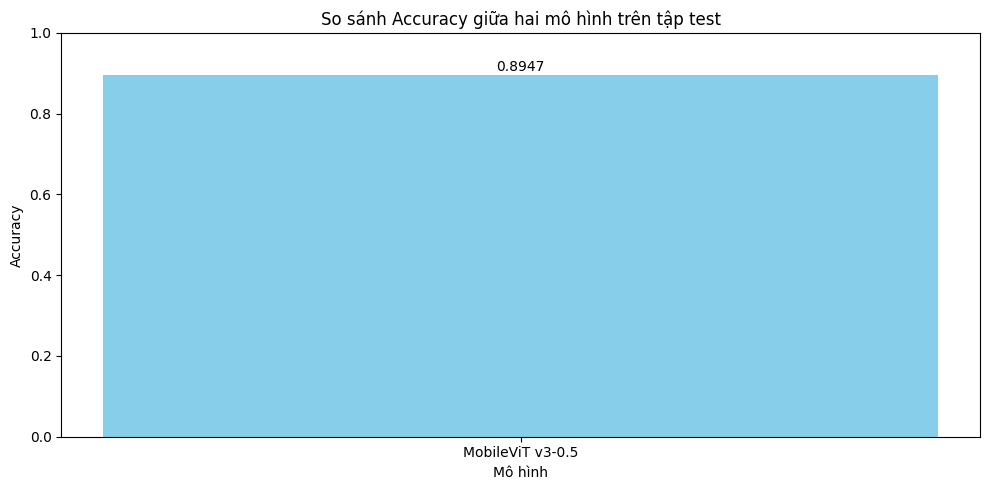

In [14]:
# Đánh giá mô hình MobileViT v3-0.5 (small) trên tập test
test_results_small = trainer_small.evaluate(processed_datasets_small["test"])
print("Kết quả MobileViT v3-0.5 trên tập test:")
print(test_results_small)


# So sánh accuracy giữa hai mô hình
small_accuracy = test_results_small.get("eval_accuracy", 0)

print("\n--- So sánh hiệu suất ---")
print(f"Accuracy của MobileViT v3-0.5: {small_accuracy:.4f}")

# Vẽ biểu đồ so sánh
plt.figure(figsize=(10, 5))
bar_width = 0.35
models = ['MobileViT v3-0.5']
accuracies = [small_accuracy]
plt.bar(models, accuracies, color=['skyblue', 'lightgreen'], width=bar_width)
plt.xlabel('Mô hình')
plt.ylabel('Accuracy')
plt.title('So sánh Accuracy giữa hai mô hình trên tập test')
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.4f}', ha='center')
plt.tight_layout()
plt.show()

In [ ]:
# Hàm để dự đoán và lấy các nhãn dự đoán
def get_predictions(trainer, dataset):
    predictions = trainer.predict(dataset)
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = predictions.label_ids
    return pred_labels, true_labels

# Lấy nhãn dự đoán và nhãn thật trên tập test cho mô hình small
pred_labels_small, true_labels_small = get_predictions(trainer_small, processed_datasets_small["test"])



# Tạo confusion matrix cho mô hình small
cm_small = confusion_matrix(true_labels_small, pred_labels_small)
labels = list(id2label.values())


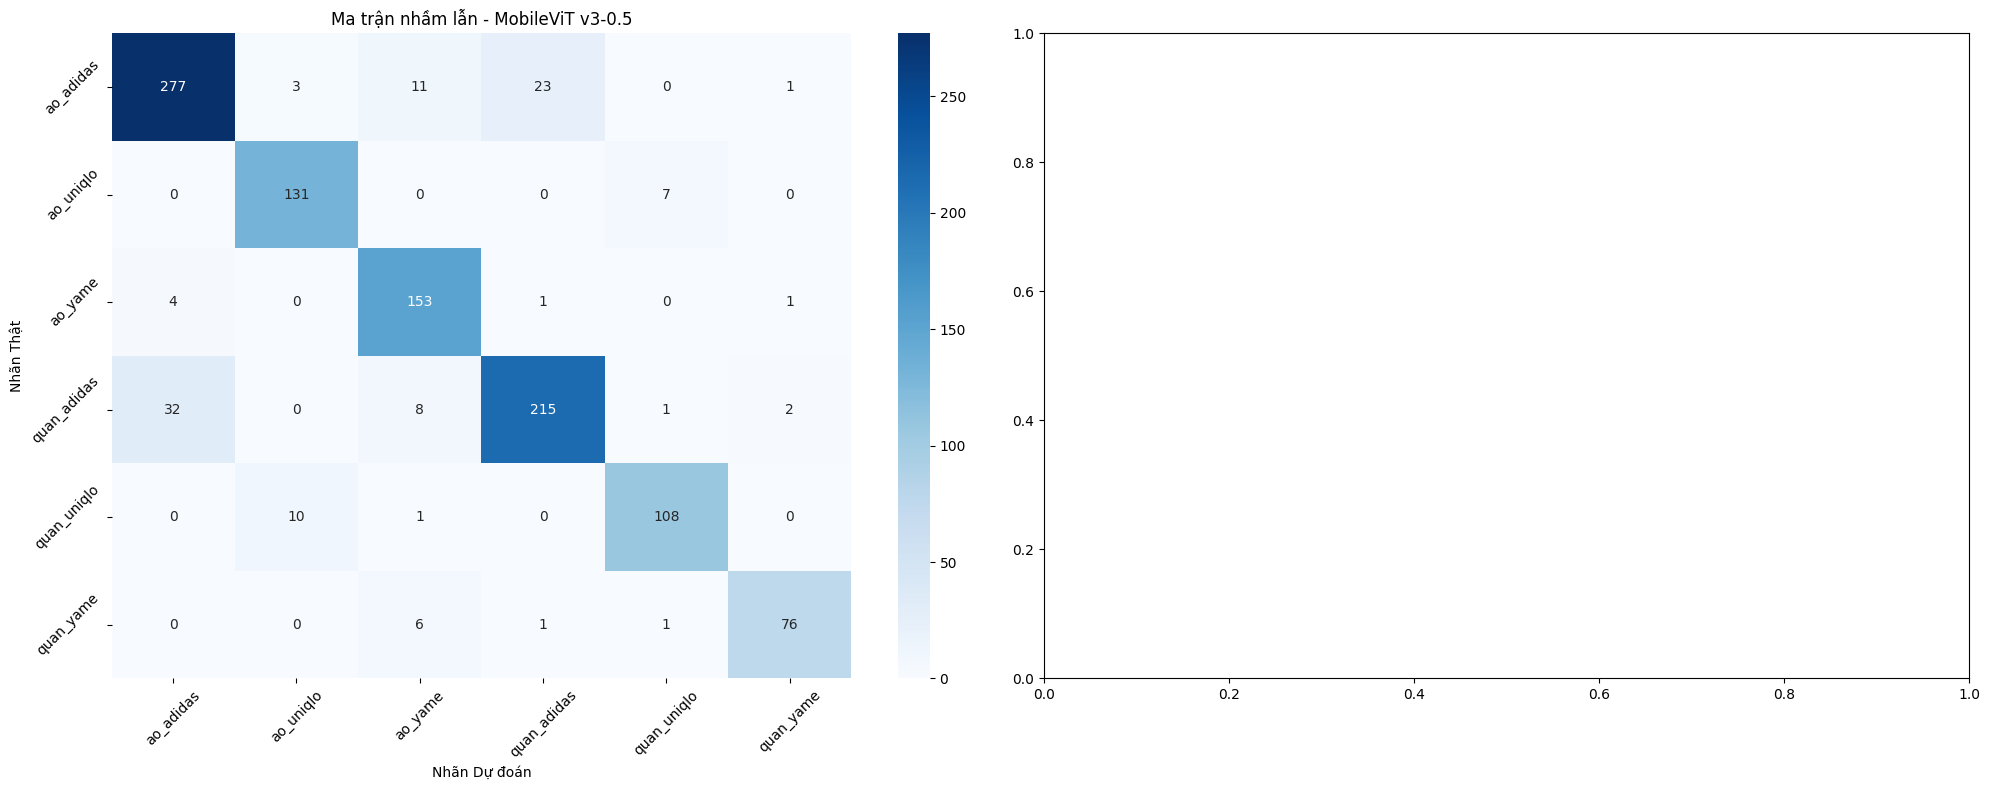

Classification Report - MobileViT v3-0.5:
              precision    recall  f1-score   support

   ao_adidas       0.88      0.88      0.88       315
   ao_uniqlo       0.91      0.95      0.93       138
     ao_yame       0.85      0.96      0.91       159
 quan_adidas       0.90      0.83      0.86       258
 quan_uniqlo       0.92      0.91      0.92       119
   quan_yame       0.95      0.90      0.93        84

    accuracy                           0.89      1073
   macro avg       0.90      0.91      0.90      1073
weighted avg       0.90      0.89      0.89      1073



In [17]:

# Vẽ confusion matrix cho cả hai mô hình
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Vẽ confusion matrix cho mô hình small
sns.heatmap(cm_small, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_xlabel('Nhãn Dự đoán')
axes[0].set_ylabel('Nhãn Thật')
axes[0].set_title('Ma trận nhầm lẫn - MobileViT v3-0.5')
axes[0].set_xticklabels(labels, rotation=45)
axes[0].set_yticklabels(labels, rotation=45)

plt.tight_layout()
plt.show()

# Hiển thị classification report cho cả hai mô hình
print("Classification Report - MobileViT v3-0.5:")
print(classification_report(true_labels_small, pred_labels_small, target_names=labels))

Tổng số dự đoán sai của mô hình: 113/1073 (10.53%)


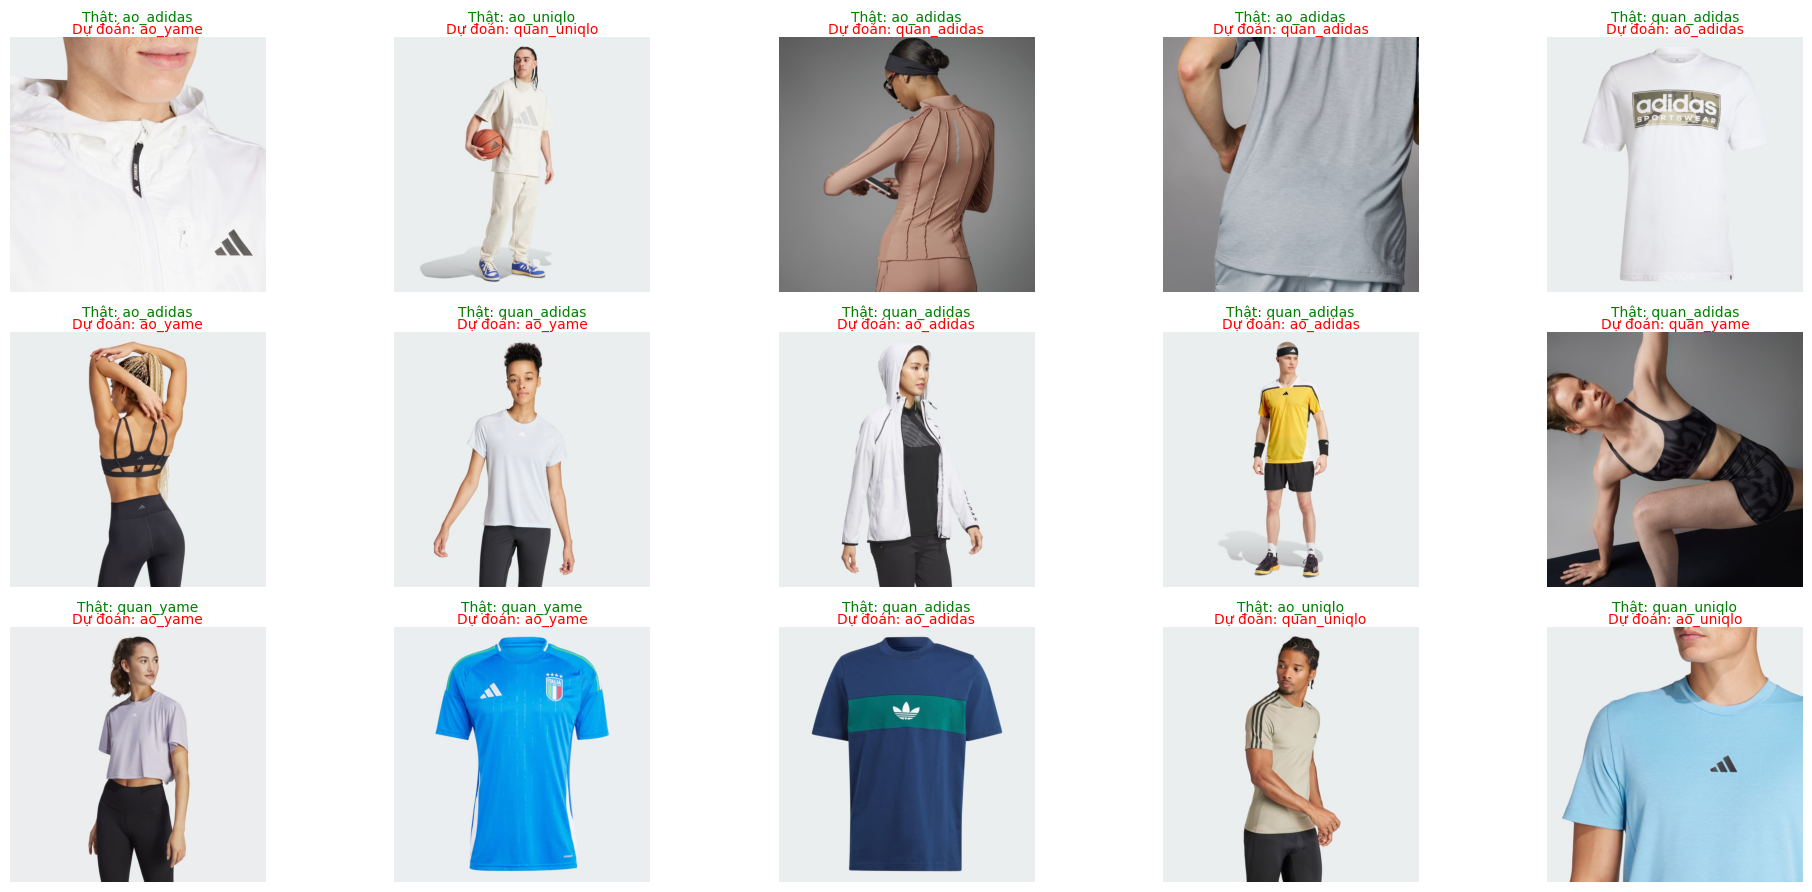

Top 5 lỗi phổ biến nhất:
1. quan_adidas → ao_adidas: 32 lần
2. ao_adidas → quan_adidas: 23 lần
3. ao_adidas → ao_yame: 11 lần
4. quan_uniqlo → ao_uniqlo: 10 lần
5. quan_adidas → ao_yame: 8 lần


In [36]:
# Phân tích các dự đoán sai của mô hình
incorrect_indices_small = np.where(pred_labels_small != true_labels_small)[0]

# Hiển thị các dự đoán sai với layout nhiều hình hơn
def display_incorrect_predictions(dataframe, indices, pred_labels, true_labels, id2label, n_samples=50, grid_size=(5, 5)):
    rows, cols = grid_size
    n_samples = min(n_samples, len(indices))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 3))
    axes = axes.flatten()
    
    for i in range(rows * cols):
        if i < n_samples:
            idx = indices[i]
            img_path = dataframe.iloc[idx]['image_dir_fixed']
            true_label = id2label[true_labels[idx]]
            pred_label = id2label[pred_labels[idx]]
            
            try:
                img = PILImage.open(img_path)
                axes[i].imshow(img)
                # Hiển thị true label màu xanh và pred label màu đỏ nếu sai
                # Sử dụng ax.text để có thể đặt màu khác nhau cho từng phần
                axes[i].text(0.5, 1.05, f"Thật: {true_label}",
                             fontsize=10,
                             color='green',
                             ha='center',
                             va='bottom',
                             transform=axes[i].transAxes)
                axes[i].text(0.5, 1.0, f"Dự đoán: {pred_label}",
                             fontsize=10,
                             color='red',
                             ha='center',
                             va='bottom',
                             transform=axes[i].transAxes)
                axes[i].axis('off')
            except Exception as e:
                print(f"Error loading image {img_path}: {e}")
                axes[i].text(0.5, 0.5, f"Error loading image\n{e}", ha='center', va='center')
                axes[i].axis('off')
        else:
            # Hide unused subplots
            axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Hiển thị các dự đoán sai của mô hình MobileViT v3-0.5
print(f"Tổng số dự đoán sai của mô hình: {len(incorrect_indices_small)}/{len(pred_labels_small)} ({len(incorrect_indices_small)/len(pred_labels_small)*100:.2f}%)")

# Hiển thị 25 dự đoán sai trong layout 5x5
display_incorrect_predictions(
    df, incorrect_indices_small, pred_labels_small, true_labels_small, id2label, n_samples=15, grid_size=(3, 5)
)

# Phân tích các loại lỗi phổ biến nhất
error_pairs = [(id2label[true_labels_small[i]], id2label[pred_labels_small[i]]) for i in incorrect_indices_small]
error_counts = {}
for true_label, pred_label in error_pairs:
    key = f"{true_label} → {pred_label}"
    error_counts[key] = error_counts.get(key, 0) + 1

# Hiển thị top 5 loại lỗi phổ biến nhất
print("Top 5 lỗi phổ biến nhất:")
for i, (error_type, count) in enumerate(sorted(error_counts.items(), key=lambda x: x[1], reverse=True)[:5]):
    print(f"{i+1}. {error_type}: {count} lần")

## 9. Tài liệu tham khảo
1. Apple Inc. (2023). "MobileViT: A Mobile-Friendly Vision Transformer for Mobile Vision Tasks". In International Conference on Learning Representations (ICLR).

2. Mehta, S., & Rastegari, M. (2022). "MobileViT: Light-weight, General-purpose, and Mobile-friendly Vision Transformer". In International Conference on Learning Representations (ICLR).

3. Hugging Face Transformers documentation: https://huggingface.co/docs/transformers/model_doc/mobilevit

4. Howard, A., Sandler, M., Chu, G., Chen, L. C., Chen, B., Tan, M., ... & Adam, H. (2019). "Searching for MobileNetV3". In Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV).

5. Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., ... & Houlsby, N. (2020). "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale." In International Conference on Learning Representations (ICLR).

6. Tác giả áo quần thời trang. (2023). Nghiên cứu phân loại sản phẩm thời trang sử dụng học sâu. Tạp chí Khoa học Công nghệ.